LG AI hackathon Smart Factory
[대회 링크](https://dacon.io/competitions/official/236055/overview/description)

# Data Description

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


# MODULE IMPORT

In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, f1_score

import tensorflow as tf 

# warning message delete 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) 

Mounted at /content/drive


# 0.Data Load

In [19]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [20]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

# 1.Preprocessing

In [21]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [22]:
# Merge 
col = ['LINE', 'PRODUCT_CODE']
train_df['line_pcode'] = train_df[col].apply(lambda row: ':'.join(row.values), axis=1)
train_df = train_df.drop(columns=['LINE', 'PRODUCT_CODE'])

# Label Encoding 
from sklearn.preprocessing import LabelEncoder
qual_col = ['line_pcode']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_df[i])
    train_df[i] = le.transform(train_df[i])
    
print('Done.')


Done.


In [23]:
# Merge 
col = ['LINE', 'PRODUCT_CODE']
test_df['line_pcode'] = test_df[col].apply(lambda row: ':'.join(row.values), axis=1)
test_df = test_df.drop(columns=['LINE', 'PRODUCT_CODE'])

# Label Encoding 
for i in qual_col:
    for label in np.unique(test_df[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_df[i] = le.transform(test_df[i])  # CAUTION: DO NOT fit test_df (only fit train_df) 
print('Done.')

Done.


# 2.Modeling_ML

In [24]:
X_train = train_df.drop(columns=['Y_Class'])
y_train = train_df['Y_Class']
test_x = test_df

In [25]:
# OverSampling for Y_Class 0, 2 
from imblearn.over_sampling import SMOTE

# 목표변수 빈도 확인
print(y_train.value_counts(1),"\n")

# Over-sampling 설정
sm = SMOTE(sampling_strategy='auto')

# train데이터를 이용한 Over-sampling
x_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 결과 확인
print('----------------------------------------------\n')
print('Over-Sampling 전:\n', y_train.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))
print("Over-Sampling 후 '2':{}".format(sum(y_resampled==2)))
print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

# 데이터 결합
train_df = pd.concat([x_resampled,y_resampled], axis=1)

1    0.680602
2    0.172241
0    0.147157
Name: Y_Class, dtype: float64 

----------------------------------------------

Over-Sampling 전:
 1    407
2    103
0     88
Name: Y_Class, dtype: int64 

Over-Sampling 후 Train X: (1221, 2877)
Over-Sampling 후 Train Y: (1221,) 

Over-Sampling 후 '2':407
Over-Sampling 후 '1':407
Over-Sampling 후 '0':407


In [26]:
X_train = train_df.drop(columns=['Y_Class','Y_Quality'])
y_train = train_df['Y_Quality']

test_x = test_df

In [27]:
test_x.isnull().sum().sum()

0

## Y_Quality 예측

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

GBR_model = GradientBoostingRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [29]:
preds=GBR_model.predict(test_x)  
print('Done.')

Done.


In [30]:
test_x['Y_Quality'] = preds
test_x  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode,Y_Quality
0,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.529662
1,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.533127
2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.531676
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.524341
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.532908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.526756
306,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.525750
307,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.528474
308,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.528166


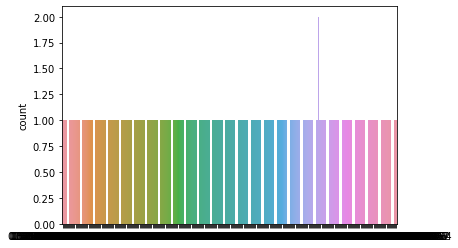

In [31]:
sns.countplot(x=preds);

## 다시 Y_Class 예측

In [32]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [33]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [35]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality']

In [36]:
test_x.isnull().sum()

Y_Quality    0
dtype: int64

In [37]:
preds = GBC_model.predict(test_x)  
print('Done.')   

Done.


In [38]:
preds

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,

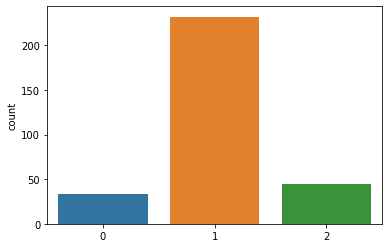

In [39]:
sns.countplot(x=preds);

In [40]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission.csv', index=False)  

## 2.2 LGBM

In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class', 'Y_Quality'])
y_train = train_df[ 'Y_Quality']

X_train

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    random_state=2023)


In [ ]:
# hyperparameter - sensitive to setting
## ==> setting is recommended.
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor()
LGBM_model.fit(X_train, y_train) 

LGBM_predict = tf.cast(LGBM_model.predict(X_test) > 0.5, 
                       dtype = tf.float32) 

print('Accuracy = ', accuracy_score(LGBM_predict, y_test))
print('Test Report = \n', classification_report(LGBM_predict, y_test))

ValueError: ignored

In [ ]:
test_x

In [ ]:
# test_x = np.array(test_df, dtype=np.float32)
selected_model = LGBM_model 

preds = selected_model.predict(X_test)  
preds

In [ ]:
sns.countplot(x=preds);

In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
y_train = train_df['Y_Class']

In [ ]:
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']   

In [ ]:
# hyperparameter - sensitive to setting
## ==> setting is recommended.
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model.fit(X_train, y_train) 

LGBM_predict = tf.cast(LGBM_model.predict(X_test) > 0.5, 
                       dtype = tf.float32)

print('Accuracy = ', accuracy_score(LGBM_predict, y_test))
print('Test Report = \n', classification_report(LGBM_predict, y_test))

## 2.3 XGBoost

In [ ]:
# hyperparameter setting isn't needed. 
from xgboost import XGBClassifier

Xgboost_model = XGBClassifier()
Xgboost_model.fit(X_train, y_train, eval_metric='aucpr')

Xg_predict = tf.cast(Xgboost_model.predict(X_test) > 0.5, 
                     dtype = tf.float32)

print('Accuracy = ', accuracy_score(Xg_predict, y_test))
print('Test Report = \n', classification_report(Xg_predict, y_test))

In [ ]:
# test_x = np.array(test_df, dtype=np.float32)
selected_model = Xgboost_model 

preds = test_x['Y_Quality']  
preds

In [ ]:
sns.countplot(x=preds);

## 2.4 RF

## 2.1 Random Forest

In [ ]:
X = train_df.drop(columns=['Y_Quality', 'Y_Class'])
y = train_df[['Y_Quality']]

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=37)

In [ ]:
y_train

,Y_Quality
48,0.533273
72,0.538095
494,0.534827
30,0.528646
32,0.548592
...,...
451,0.530294
22,0.517719
437,0.526906
251,0.529097


In [ ]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators = 10,
                                            oob_score=False)
RF_fitted = RF_model.fit(X_train, y_train)
preds = tf.cast(RF_fitted.predict(X_test) > 0.5, 
                     dtype = tf.float32)

# print('Accuracy = ', accuracy_score(RF_predict, y_test))
# print("Test Report = \n", classification_report(RF_predict, y_test))

<ipython-input-132-8cbca3e2ef17>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_fitted = RF_model.fit(X_train, y_train)


In [ ]:
print(RF_fitted.score(X_train, y_train))
print(RF_fitted.score(X_test, y_test))

0.908770671112057
0.4940122172033936


In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [ ]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [ ]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality']

In [ ]:
test_x.isnull().sum()

Y_Quality    0
dtype: int64

In [ ]:
preds = GBC_model.predict(test_x)  
print('Done.')   

Done.


In [ ]:
preds

array(['1', '1', '1', '0', '0', '0', '0', '2', '2', '0', '0', '0', '0',
       '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '0', '0',
       '0', '0', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '2', '2', '2', '1', '1', '1', '1', '1', '1', '2', '1', '1', '2',
       '2', '2', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1',
       '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

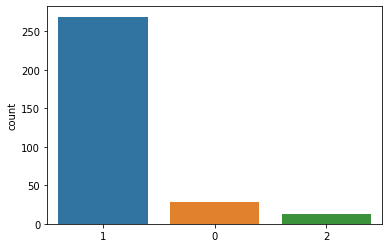

In [ ]:
sns.countplot(x=preds, order=['0','1','2']);